<a href="https://colab.research.google.com/github/khmelkoff/TraxRuSummarizer/blob/main/TraxRuSummarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install trax

     |████████████████████████████████| 522kB 5.4MB/s 
     |████████████████████████████████| 215kB 7.7MB/s 
     |████████████████████████████████| 3.4MB 9.3MB/s 
     |████████████████████████████████| 1.2MB 41.4MB/s 
     |████████████████████████████████| 368kB 48.0MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 3.8MB 45.8MB/s 
     |████████████████████████████████| 1.8MB 50.3MB/s 
     |████████████████████████████████| 890kB 38.6MB/s 
     |████████████████████████████████| 2.9MB 52.6MB/s 


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
# from unicodedata import normalize
import sentencepiece as spm

import trax
from trax import layers as tl
from trax.fastmath import numpy as jnp

%matplotlib inline

In [84]:
import textwrap
wrapper = textwrap.TextWrapper(width=70)

## Load the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/lenta-ru-news.csv.zip')
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


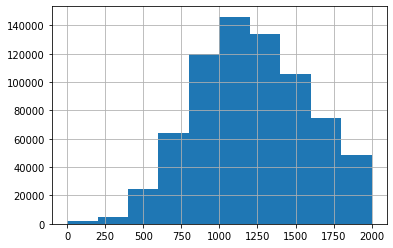

In [8]:
data['text_len'] = [len(x) if not type(x)==float else 0 for x in data.text]
data.text_len[data.text_len < 2000].hist()

In [9]:
# text_full = []  # full text list for train senttence piece tokenizer
text_pairs = [] # paired data for train the model, format: (title, text)
for i in tqdm(range(data.shape[0])):
    if data.iloc[i, 6] >= 200 and data.iloc[i, 6] <= 2000:
        # text_full.append(data.iloc[i, 1] + '\n' + data.iloc[i, 2])
        # list of (article, summary)
        text_pairs.append((data.iloc[i, 2], data.iloc[i, 1]))

# save full text to text file        
# with open('full_text.txt', 'w', encoding='utf-8') as file:
#     file.write('\n'.join(text_full))  

100%|██████████| 800975/800975 [01:10<00:00, 11334.76it/s]


## Load / Train BPE tokenizer

In [10]:
# train tokenizer
# spm.SentencePieceTrainer.train('--input=full_text.txt --pad_id=0 --bos_id=-1 --eos_id=1 --unk_id=2 \
#                                --model_prefix=bpe --vocab_size=32000 --model_type=bpe')
sp = spm.SentencePieceProcessor()
sp.load('/content/drive/MyDrive/bpe.model')

True

In [14]:
s0 = text_pairs[10][0]
print(s0[:300])

Сегодня областной центр Сахалина и Курил получил статус очага распространения холеры. Как сообщает ИТАР-ТАСС со ссылкой на пресс-центр администрации Сахалинской области, в лечебных учреждениях Южно-Сахалинска уже находятсятся 5 горожан, причем у двоих из них болезнь проходит в средне-тяжелой форме. 


In [15]:
# tokenizer check
print('encode: text => id:')
print(sp.encode_as_pieces(s0[:300]))
print('')
print(sp.encode_as_ids(s0[:300]))
print('')
print('decode: id => text:')
print(sp.decode_pieces(sp.encode_as_pieces(s0[:300])))
print('')
print(f'Beginning of sentence id: {sp.bos_id()}')
print(f'Pad id: {sp.pad_id()}')
print(f'End of sentence id: {sp.eos_id()}')
print(f'Unknown id: {sp.unk_id()}')
print(f'Vocab size: {sp.vocab_size()}')      

encode: text => id:
['▁Сегодня', '▁областной', '▁центр', '▁Саха', 'лина', '▁и', '▁Ку', 'рил', '▁получил', '▁статус', '▁оча', 'га', '▁распространения', '▁хол', 'еры', '.', '▁Как', '▁сообщает', '▁ИТАР', '-', 'ТАСС', '▁со', '▁ссылкой', '▁на', '▁пресс', '-', 'центр', '▁администрации', '▁Сахалинской', '▁области', ',', '▁в', '▁лечеб', 'ных', '▁учреждениях', '▁Южно', '-', 'Сахалин', 'ска', '▁уже', '▁находятся', 'тся', '▁5', '▁горожан', ',', '▁причем', '▁у', '▁двоих', '▁из', '▁них', '▁болезнь', '▁проходит', '▁в', '▁средне', '-', 'тяже', 'лой', '▁форме', '.']

[16150, 9165, 4486, 18298, 3758, 18, 1074, 3060, 1591, 7575, 18586, 130, 13021, 22248, 1246, 31898, 478, 259, 4139, 31910, 3818, 47, 902, 26, 781, 31910, 10069, 2561, 28178, 916, 31894, 5, 26236, 113, 21915, 12460, 31910, 18542, 276, 575, 2885, 293, 485, 21188, 31894, 5968, 46, 10049, 95, 1019, 22517, 4601, 5, 15079, 31910, 14667, 2931, 7543, 31898]

decode: id => text:
Сегодня областной центр Сахалина и Курил получил статус очага распрос

In [16]:
uid = 18298
spiece = "\u2581Саха"
unknown = "_НЕИЗВЕСТНОСТЬ_"

# id <=> piece conversion
print(f'SentencePiece for ID {uid}: {sp.id_to_piece(uid)}')
print(f'ID for Sentence Piece {spiece}: {sp.piece_to_id(spiece)}')

# returns 0 for unknown tokens (we can change the id for UNK)
print(f'ID for unknown text {unknown}: {sp.piece_to_id(unknown)}')

SentencePiece for ID 18298: ▁Саха
ID for Sentence Piece ▁Саха: 18298
ID for unknown text _НЕИЗВЕСТНОСТЬ_: 2


In [17]:
# vocab's head and tail test
print('\nId\tSentP\tControl?')
print('------------------------')
for uid in range(7):
    print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')
    
for uid in range(sp.vocab_size()-7,sp.vocab_size()):
    print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')


Id	SentP	Control?
------------------------
0	<pad>	True
1	</s>	True
2	<unk>	False
3	▁п	False
4	ст	False
5	▁в	False
6	▁с	False
31993	V	False
31994	x	False
31995	J	False
31996	z	False
31997	K	False
31998	U	False
31999	X	False


## Data: preprocess and create generators

In [28]:
# inintial shuffling
random.shuffle(text_pairs)
margin = int(len(text_pairs)*0.9)
train_text_pairs = text_pairs[:margin]
print('train cases: ', len(train_text_pairs))
eval_text_pairs = text_pairs[margin:]
print('eval cases: ', len(eval_text_pairs))

train cases:  650157
eval cases:  72240


In [30]:
def data_generator(data, shuffle=True):
    '''
      Input: 
        data - list containing tuples (article, summary)
        shuffle - If True: shuffle the data order
      Output:
        a tuple containing 2 elements:
        article
        summary
    '''
    
    data_lng = len(data) # len(data)
    index_list = [*range(data_lng)] # Create a list with the ordered indexes of sample data
    
    index = 0 # Start with the first element
    while True:
        # Wrap the index each time that we reach the end of the list
        if index >= data_lng:
            index = 0

        if shuffle:
            random.shuffle(index_list) # re-shuffle the order
            
        sample = data[index_list[index]]
        index += 1
        yield(sample)

# create data streams
def train_data_stream():
    return data_generator(train_text_pairs, shuffle=True)

def eval_data_stream():
    return data_generator(eval_text_pairs, shuffle=True)        

In [48]:
def tokenize(input_str, EOS=1):
    """Input str to features dict, ready for inference"""
  
    # Use the trax.data.tokenize method. It takes streams and returns streams,
    # we get around it by making a 1-element stream with `iter`.
    inputs =  next(trax.data.tokenize(iter([input_str]),
                                      vocab_type='sentencepiece',
                                      vocab_dir='/content/drive/MyDrive/',
                                      vocab_file='bpe.model'),
                                      
                   )
    
    # Mark the end of the sentence with EOS
    return list(inputs) + [EOS]

def detokenize(integers):
    """List of ints to str"""
  
    s = trax.data.detokenize(integers,
                             vocab_type='sentencepiece',
                             vocab_dir='/content/drive/MyDrive/',
                             vocab_file='bpe.model')
    
    return s

In [49]:
detokenize(tokenize('Сведения о пассажирах на всех видах транспорта, где используются именные проездные билеты', EOS=1))

'Сведения о пассажирах на всех видах транспорта, где используются именные проездные билеты'

In [77]:
# Special tokens
SEP = 0 # Padding or separator token
EOS = 1 # End of sentence token

# Concatenate tokenized inputs and targets using 0 as separator.
def preprocess(stream):
    for (article, summary) in stream:
        joint = np.array(list(article) + [EOS, SEP] + list(summary) + [EOS])
        mask = [0] * (len(list(article)) + 2) + [1] * (len(list(summary)) + 1) 
        yield joint, joint, np.array(mask)

# You can combine a few data preprocessing steps into a pipeline like this.
input_pipeline = trax.data.Serial(
    # Tokenizes
    trax.data.Tokenize(vocab_type='sentencepiece',
                       vocab_dir='/content/drive/MyDrive/',
                       vocab_file='bpe.model'),
    # Uses function defined above
    preprocess,
)

# Apply preprocessing to data streams.
train_stream = input_pipeline(train_data_stream())
eval_stream = input_pipeline(eval_data_stream())

In [81]:
train_input, train_target, train_mask = next(train_stream)
# assert sum((train_input - train_target)**2) == 0  # They are the same in Language Model (LM).

In [88]:
# check pad (id:0) and sep/eos (id:1)
print(train_input[-20:])

[ 7127  6298    72   756   721   557 31898     1     0   267 12173 15305
  4546  9251  4690  4165   314  1137   589     1]


## Batching and Bucketing 

In [89]:
# batch of 8 sentences of length < 256 , 4 of length < 512....
boundaries =  [256, 512, 1024]
batch_sizes = [8, 4, 2, 1]

# Create the streams.
train_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(train_stream)

eval_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(eval_stream)

In [92]:
input_batch, _, mask_batch = next(train_batch_stream)

# Shape of the input_batch
input_batch.shape

(8, 256)

In [93]:
# check autopadding endig of sample
# 1, 0, <not 0 digit>... - end of article and start of summary
input_batch[0]

array([   61,  6596, 10552, 17248,  5675,  3717,  2513,     6, 26185,
        1206, 31898,  5552,  3878,  1163, 25620, 24843, 31894,    74,
          13,   201,  1768,    44,     6,    26, 30827,  1991,  1139,
       15610,  4546,   603, 31898,   478,  1618,   809,    82,  2354,
       31905,     5,  3211,  6596, 31894, 26563,  4430,     5,  1860,
          26,  1253, 16796, 31886, 17888, 27708, 23296, 31910,  3015,
         603, 31884,   100,     5,  1831,  3783,   133, 14159,  2150,
         888,   643, 31898,  1397,    13,   201,  1768,    44,   725,
        2472, 22742, 13859,     5,   851,  3684, 31212,  1395,  2996,
       19203,    18,  2851,    39,  3083, 11276,   161,  2513,   156,
          74,  5600, 31898,   513,   128,   542, 13455,  6658,    29,
          59,  4857, 31898,    61,   888,   643,   575,   102, 13006,
       15318,  5944,  3211,   274,  4159,  6123,    18, 10573,  2890,
       31898,     1,     0,    61,  6596,    76,    42,  8587,  4546,
         603,  2851,

## Transformer Model

In [ ]:
def SumTransformer():
    pass